# Setup

In [90]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from generate_results import initialize
from environments.ace_dice.computation_utils import custom_sigmoid

In [91]:
plt.style.use('seaborn-v0_8-colorblind')
print(plt.style.available)
# Define colors by converting RGB to [0, 1] scale
color_red = (182/255, 0/255, 0/255) # UiO red
color_black = (0/255, 0/255, 0/255) # Black
color_gray = (178/255, 179/255, 183/255) # UiO grey


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [92]:
# General utility functions
def load_csv(file_path: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(file_path)
        return df
    except Exception as e:
        print(f"Error loading CSV: {e}")

def get_years(num_time_steps: int) -> np.ndarray:
    """Returns vectors of years with 5-year time steps, starting at year 0.

    Args:
        num_time_steps (int): Total number of time steps to return year vector for.

    Returns:
        np.ndarray: An array of years starting from year 0, stepping by 5 years.
    """
    start_year = 0
    end_year = start_year + 5 * num_time_steps - 5
    
    years = np.arange(start_year, end_year + 1, 5)
    
    return years

errorstr = "The data does not have enough entries for the requested number of time steps."


In [93]:
env2016, agent2016 = initialize("2016")
env2023, agent2023 = initialize("2023")



Restoring policy network from C:\Users\herma\OneDrive\Skrivebord\DNN-for-ACE\logs/2016/checkpoints\ckpt-663

Restoring policy network from C:\Users\herma\OneDrive\Skrivebord\DNN-for-ACE\logs/2023/checkpoints\ckpt-1098


In [94]:
# Loading data and defining ranges
csv_path2016 = 'plots/results/ACE_DICE2016/trajectories/csv/trajectory_data.csv'
df2016 = load_csv(csv_path2016)
print(df2016.head())

csv_path2023 = 'plots/results/ACE_DICE2023/trajectories/csv/trajectory_data.csv'
df2023 = load_csv(csv_path2023)
print(df2023.head())

num_time_steps = 80
year_labels = get_years(num_time_steps)

        k_t       M_1_t      M_2_t      M_3_t   tau_1_t   tau_2_t    t  \
0  5.407172   862.86000  1541.1100  10010.440  1.256727  1.185465  0.0   
1  6.511661   897.89820  1557.4984  10010.915  1.293235  1.186274  1.0   
2  7.019762   952.20905  1576.3011  10011.430  1.329969  1.187489  2.0   
3  7.310959  1016.72546  1599.1158  10011.991  1.374899  1.189106  3.0   
4  7.515522  1086.66600  1626.6765  10012.610  1.429080  1.191216  4.0   

        x_t       E_t        V_t  lambda_k_t  lambda_m_1  lambda_m_2  \
0  0.588434  3.222510  41.300350    0.502798    0.003276   -0.002530   
1  0.563320  3.310972  43.088240    0.594026    0.005622   -0.006270   
2  0.550578  3.337191  44.115746    0.634027    0.007689   -0.005646   
3  0.544198  3.354748  44.794810    0.657272    0.007840   -0.003433   
4  0.540440  3.369075  45.338924    0.673949    0.007530   -0.001259   

   lambda_m_3  lambda_tau_1  lambda_tau_2  lambda_t_BAU  lambda_E_t  
0    0.009187     -0.060471     -0.051237     -0.025

# Plotting state variables

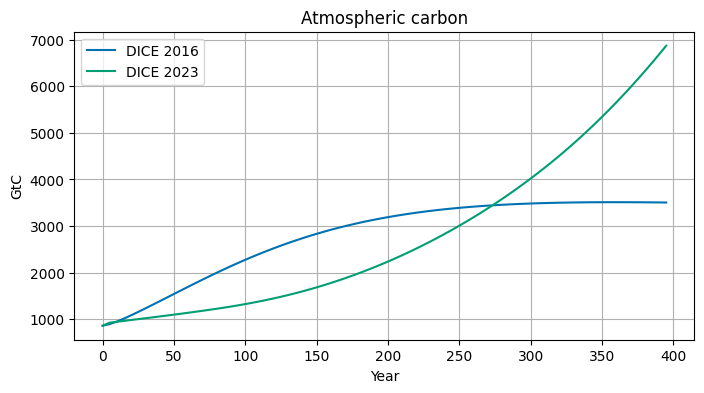

In [95]:
if len(df2016['M_1_t']) >= num_time_steps:
    plt.figure(figsize=(8, 4))
    plt.plot(year_labels, df2016['M_1_t'][:num_time_steps], label='DICE 2016')
    plt.plot(year_labels, df2023['M_1_t'][:num_time_steps], label='DICE 2023')
    plt.title('Atmospheric carbon')
    plt.xlabel('Year')
    plt.ylabel('GtC')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    raise ValueError(errorstr)

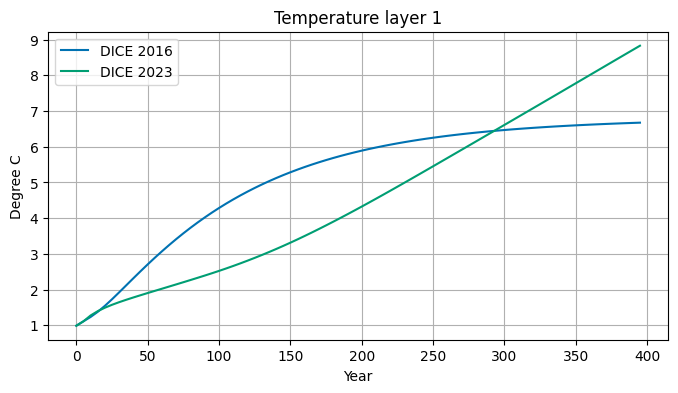

In [96]:
if not len(df2016['tau_1_t']) >= num_time_steps:
    raise ValueError(errorstr)

normal_temperatures2016 = np.log(df2016['tau_1_t'][:num_time_steps]) / env2016.equations_of_motion.xi_1.numpy()
normal_temperatures2023 = np.log(df2023['tau_1_t'][:num_time_steps]) / env2023.equations_of_motion.xi_1.numpy()

plt.figure(figsize=(8, 4))
plt.plot(year_labels, normal_temperatures2016, label='DICE 2016')
plt.plot(year_labels, normal_temperatures2023, label='DICE 2023')
plt.title('Temperature layer 1')
plt.xlabel('Year')
plt.ylabel('Degree C')
plt.legend()
plt.grid(True)
plt.show()

## probably not gonna use

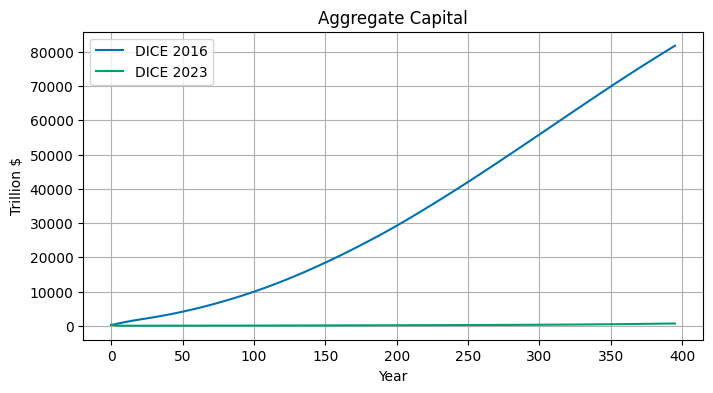

In [97]:
# Plotting capital
if not len(df2016['tau_1_t']) >= num_time_steps:
    raise ValueError(errorstr)

capital2016 = np.exp(df2016["k_t"][:num_time_steps])
capital2023 = np.exp(df2023["k_t"][:num_time_steps])

plt.figure(figsize=(8, 4))
plt.plot(year_labels, capital2016, label='DICE 2016')
plt.plot(year_labels, capital2023, label='DICE 2023')
plt.title('Aggregate Capital')
plt.xlabel('Year')
plt.ylabel('Trillion $')
plt.legend()
plt.grid(True)
plt.show()

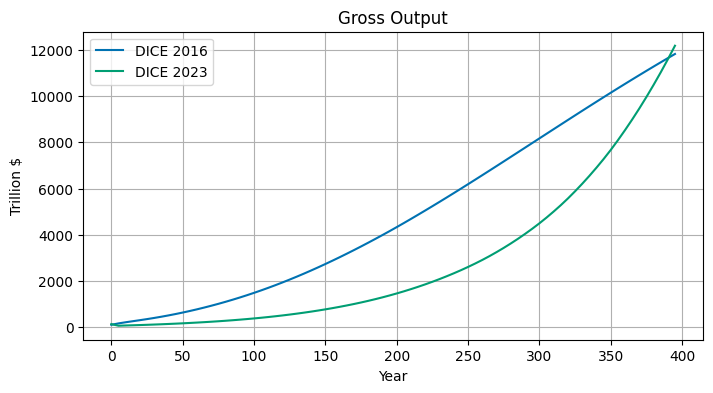

In [98]:
# Plotting output
if not len(df2016['tau_1_t']) >= num_time_steps:
    raise ValueError(errorstr)

# 2016 gross output
k_t_tensor2016 = tf.convert_to_tensor(df2016["k_t"], dtype=tf.float32)
E_t_tensor2016 = tf.convert_to_tensor(df2016["E_t"], dtype=tf.float32)
gross_output2016 = [np.exp(env2016.equations_of_motion.log_Y_t(k_t_tensor2016[t], E_t_tensor2016[t], t).numpy()) for t in range(num_time_steps)]

# 2023 gross output
k_t_tensor2023 = tf.convert_to_tensor(df2023["k_t"], dtype=tf.float32)
E_t_tensor2023 = tf.convert_to_tensor(df2023["E_t"], dtype=tf.float32)
gross_output2023 = [np.exp(env2023.equations_of_motion.log_Y_t(k_t_tensor2023[t], E_t_tensor2023[t], t).numpy()) for t in range(num_time_steps)]


plt.figure(figsize=(8, 4))
plt.plot(year_labels, gross_output2016, label='DICE 2016')
plt.plot(year_labels, gross_output2023, label='DICE 2023')
plt.title('Gross Output')
plt.xlabel('Year')
plt.ylabel('Trillion $')
plt.legend()
plt.grid(True)
plt.show()

# Plotting action variables

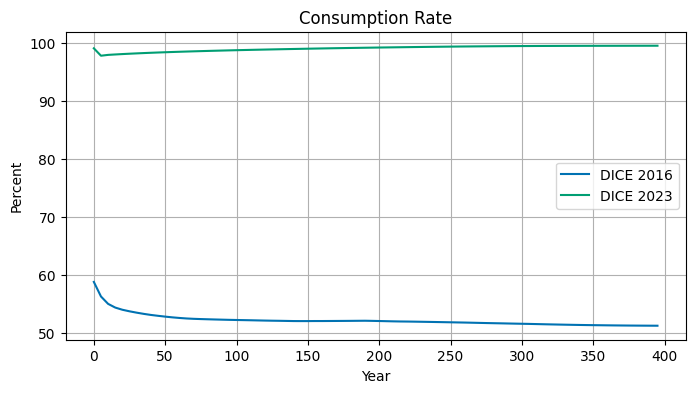

In [99]:
# Plotting consumption
if not len(df2016['x_t']) >= num_time_steps:
    raise ValueError(errorstr)
    
consumption2016 = df2016['x_t'][:num_time_steps] * 100 # Turning into percent
consumption2023 = df2023['x_t'][:num_time_steps] * 100

plt.figure(figsize=(8, 4))
plt.plot(year_labels, consumption2016, label='DICE 2016')
plt.plot(year_labels, consumption2023, label='DICE 2023')
plt.title('Consumption Rate')
plt.xlabel('Year')
plt.ylabel('Percent')
plt.legend()
plt.grid(True)
plt.show()


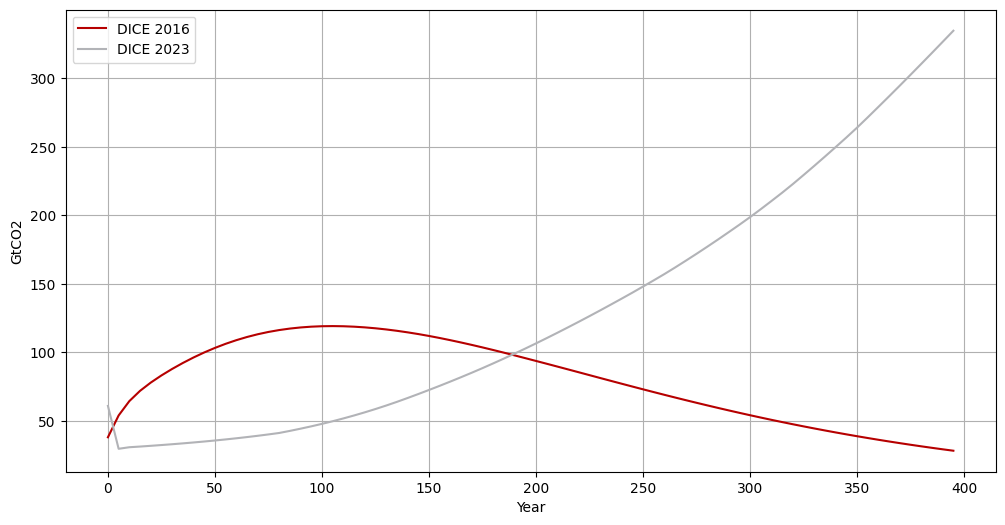

In [100]:
# Plotting emissions
if not len(df2016['E_t']) >= num_time_steps:
    raise ValueError(errorstr)

# Deriving emissions for ACEDICE 2016
emissions2016 = []
emissions2016_bau = []
for t in range(num_time_steps):
    k_t = tf.convert_to_tensor(df2016["k_t"][t], dtype=tf.float32)
    E_t_BAU = env2016.equations_of_motion.E_t_BAU(t, k_t)
    E_t_raw = tf.convert_to_tensor(df2016["E_t"][t], dtype=tf.float32)
    E_t = custom_sigmoid(E_t_raw, E_t_BAU).numpy()

    total_E_t = E_t + env2016.equations_of_motion.E_t_EXO[t].numpy()
    emissions2016.append(total_E_t)
    emissions2016_bau.append(E_t_BAU.numpy()+env2016.equations_of_motion.E_t_EXO[t].numpy())
emissions2016 = np.array(emissions2016)
emissions2016_bau = np.array(emissions2016_bau)

# Deriving emissions for ACEDICE 2023
emissions2023 = []
emissions2023_bau = []
for t in range(num_time_steps):
    k_t = tf.convert_to_tensor(df2023["k_t"][t], dtype=tf.float32)
    E_t_BAU = env2023.equations_of_motion.E_t_BAU(t, k_t)
    E_t_exo = env2023.equations_of_motion.E_t_EXO[t]
    E_t_raw = tf.convert_to_tensor(df2023["E_t"][t], dtype=tf.float32)
    E_t = custom_sigmoid(E_t_raw, E_t_BAU+E_t_exo).numpy()

    total_E_t = E_t
    emissions2023.append(total_E_t)
    emissions2023_bau.append(E_t_BAU.numpy()+env2023.equations_of_motion.E_t_EXO[t].numpy())

emissions2023 = np.array(emissions2023)
emissions2023_bau = np.array(emissions2023_bau)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(year_labels, emissions2016, label='DICE 2016', color = color_red)
plt.plot(year_labels, emissions2023, label='DICE 2023', color = color_gray)
plt.xlabel('Year')
plt.ylabel('GtCO2')
plt.legend()
plt.grid(True)
plt.show()

# Optimality Check

(equation 8): $SCC_t = \frac{\beta^2 Y_t^{net}}{M_{pre}} \xi_0 [(1-\beta\sigma)^{-1}]_{1,1} \sigma^{forc}[(1-\beta\Phi)^{-1}]_{1,1}$

(equation 11): $\mu_t = \left( \frac{\Gamma_t}{p_t^{back}[1-D(T_{1,t})]} \right)^{\frac{1}{\theta_2 - 1}}$, with $\Gamma_t = SCC_t$ in my case, as I don't have any Hotelling rent.

Note, SCC equation in ACE paper (number 11 and number 8 in emissions analysis paper) does not have $\beta^2$, but $\beta$

#### SCC Calculation

##### 2016 caculations

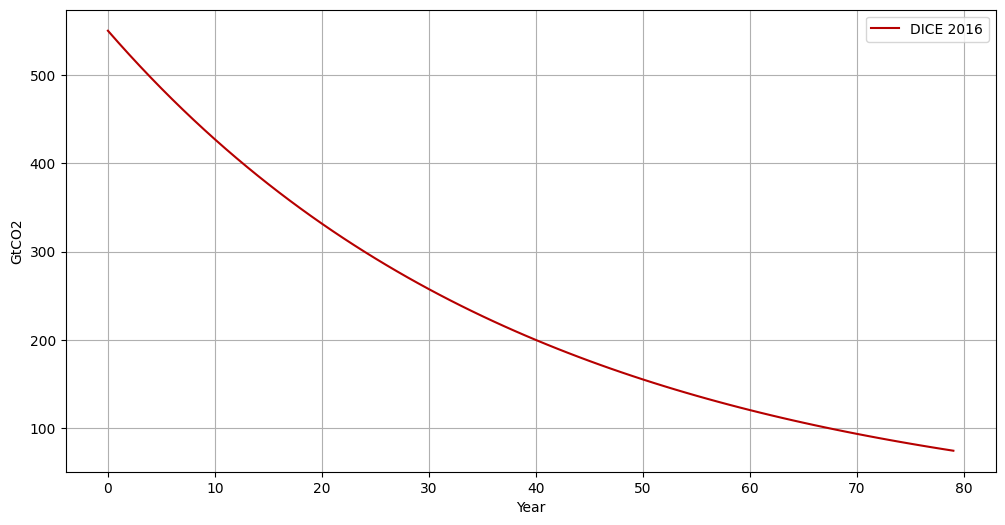

In [101]:
plt.figure(figsize=(12, 6))
plt.plot(env2016.equations_of_motion.pbacktime[:80], label='DICE 2016', color = color_red)
plt.xlabel('Year')
plt.ylabel('GtCO2')
plt.legend()
plt.grid(True)
plt.show()

In [102]:
# Calculating the temperature dynamics inverse
sigma = env2016.equations_of_motion.sigma_transition
tensor_shape = sigma.shape[0]
ones_matrix = tf.eye(num_rows=tensor_shape, dtype=tf.float32)

matrix_to_invert = ones_matrix - (env2016.equations_of_motion.beta * sigma)
inverse_matrix = tf.linalg.inv(matrix_to_invert)

temp_dyn_inverse = inverse_matrix[0, 0].numpy()

# ---------------------------------- #
# Calculating the carbon dynamics inverse
phi = env2016.equations_of_motion.Phi
tensor_shape = phi.shape[0]
ones_matrix = tf.eye(num_rows=tensor_shape, dtype=tf.float32)

matrix_to_invert = ones_matrix - env2016.equations_of_motion.beta * phi
inverse_matrix = tf.linalg.inv(matrix_to_invert)

carbon_dyn_inverse = inverse_matrix[0, 0].numpy()

print(temp_dyn_inverse, carbon_dyn_inverse)

2.1404703 5.1415606


In [103]:
# Constants
xi_0 = env2016.equations_of_motion.xi_0.numpy()
beta_squared = np.square(env2016.equations_of_motion.beta.numpy())
m_pre = env2016.equations_of_motion.M_pre.numpy()
sigma_forc = env2016.equations_of_motion.sigma_forc.numpy()
constant_part = (beta_squared/m_pre)*xi_0 * temp_dyn_inverse * sigma_forc * carbon_dyn_inverse

damages = 1 - np.exp(-xi_0*df2016["tau_1_t"][:num_time_steps]+xi_0)
net_output = gross_output2016*(np.ones_like(damages)-damages)
scc2016 = net_output * constant_part


##### 2023 Calculations

In [104]:
# Calculating the temperature dynamics inverse
sigma = env2023.equations_of_motion.sigma_transition
tensor_shape = sigma.shape[0]
ones_matrix = tf.eye(num_rows=tensor_shape, dtype=tf.float32)

matrix_to_invert = ones_matrix - (env2023.equations_of_motion.beta * sigma)
inverse_matrix = tf.linalg.inv(matrix_to_invert)

temp_dyn_inverse = inverse_matrix[0, 0].numpy()

# ---------------------------------- #
# Calculating the carbon dynamics inverse
phi = env2023.equations_of_motion.Phi
tensor_shape = phi.shape[0]
ones_matrix = tf.eye(num_rows=tensor_shape, dtype=tf.float32)

matrix_to_invert = ones_matrix - env2023.equations_of_motion.beta * phi
inverse_matrix = tf.linalg.inv(matrix_to_invert)

carbon_dyn_inverse = inverse_matrix[0, 0].numpy()

print(temp_dyn_inverse, carbon_dyn_inverse)

2.1404703 5.1415606


In [105]:
# Constants
xi_0 = env2023.equations_of_motion.xi_0.numpy()
beta_squared = np.square(env2023.equations_of_motion.beta.numpy())
m_pre = env2023.equations_of_motion.M_pre.numpy()
sigma_forc = env2023.equations_of_motion.sigma_forc.numpy()
constant_part = (beta_squared/m_pre)*xi_0 * temp_dyn_inverse * sigma_forc * carbon_dyn_inverse

damages = 1 - np.exp(-xi_0*df2023["tau_1_t"][:num_time_steps]+xi_0)
net_output = gross_output2023*(np.ones_like(damages)-damages)
scc2023 = net_output * constant_part


##### Final plot

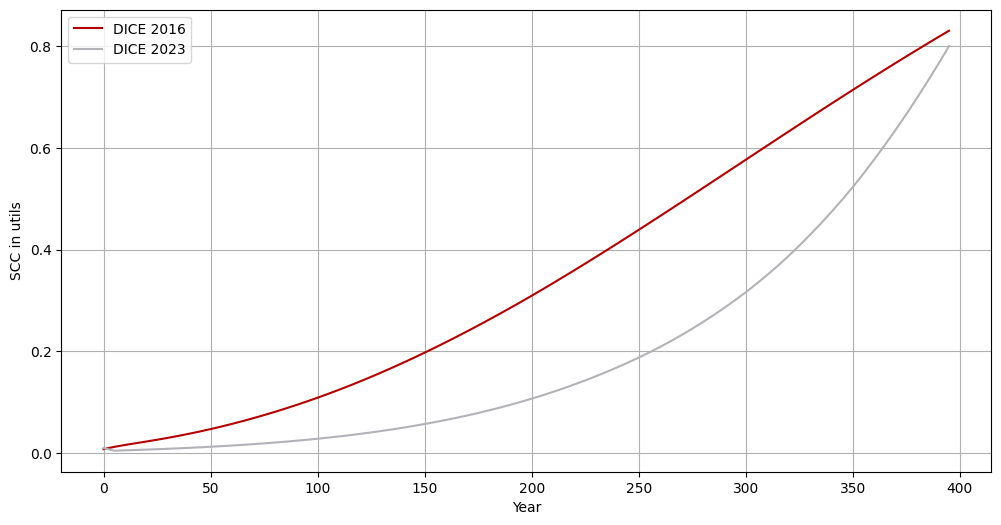

In [106]:
plt.figure(figsize=(12, 6))
plt.plot(year_labels, scc2016, label='DICE 2016', color = color_red)
plt.plot(year_labels, scc2023, label='DICE 2023', color = color_gray)
plt.xlabel('Year')
plt.ylabel('SCC in utils')
plt.legend()
plt.grid(True)
plt.show()

## Calculating optimal abatement rate 

In [107]:
# Calculations for 2016
theta_2 = env2016.equations_of_motion.theta_2.numpy()
p_back = env2016.equations_of_motion.pbacktime.numpy()[:num_time_steps]

exponent = 1 / (theta_2 - 1)
optimal_abatement_rate_2016 = [np.power(scc2016[t]/(p_back[t]*(1-damages[t])), exponent) for t in range(num_time_steps)]

In [108]:
# Calculations for 2023
theta_2 = env2023.equations_of_motion.theta_2.numpy()
p_back = env2023.equations_of_motion.pbacktime.numpy()[:num_time_steps]

exponent = 1 / (theta_2 - 1)
optimal_abatement_rate_2023 = [np.power(scc2023[t]/(p_back[t]*(1-damages[t])), exponent) for t in range(num_time_steps)]

In [109]:
# Getting abatement rates
abatement_rate_2016 = 1 - emissions2016 / emissions2016_bau
abatement_rate_2023 = 1 - emissions2023 / emissions2023_bau

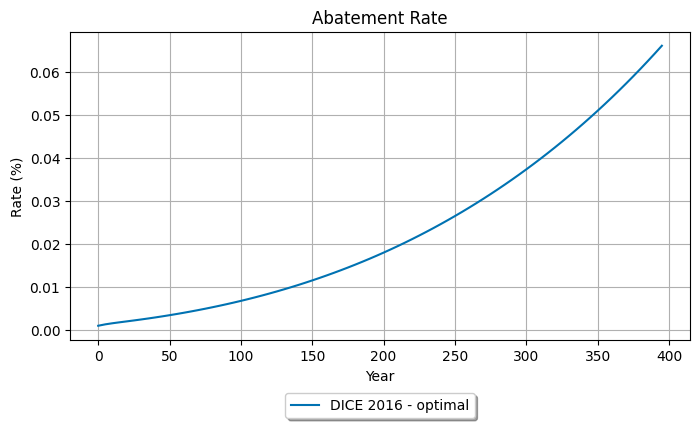

In [126]:

lm = num_time_steps
plt.figure(figsize=(8, 4))
plt.plot(year_labels[:lm], optimal_abatement_rate_2016[:lm], label='DICE 2016 - optimal')
#plt.plot(year_labels[:lm], optimal_abatement_rate_2023[:lm], label='DICE 2023 - optimal')
#plt.plot(year_labels[:lm], abatement_rate_2016[:lm], label='DICE 2016 - estimated')
#plt.plot(year_labels[:lm], abatement_rate_2023[:lm], label='DICE 2023 - estimated')
plt.title('Abatement Rate')
plt.xlabel('Year')
plt.ylabel('Rate (%)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
plt.grid(True)
plt.show()

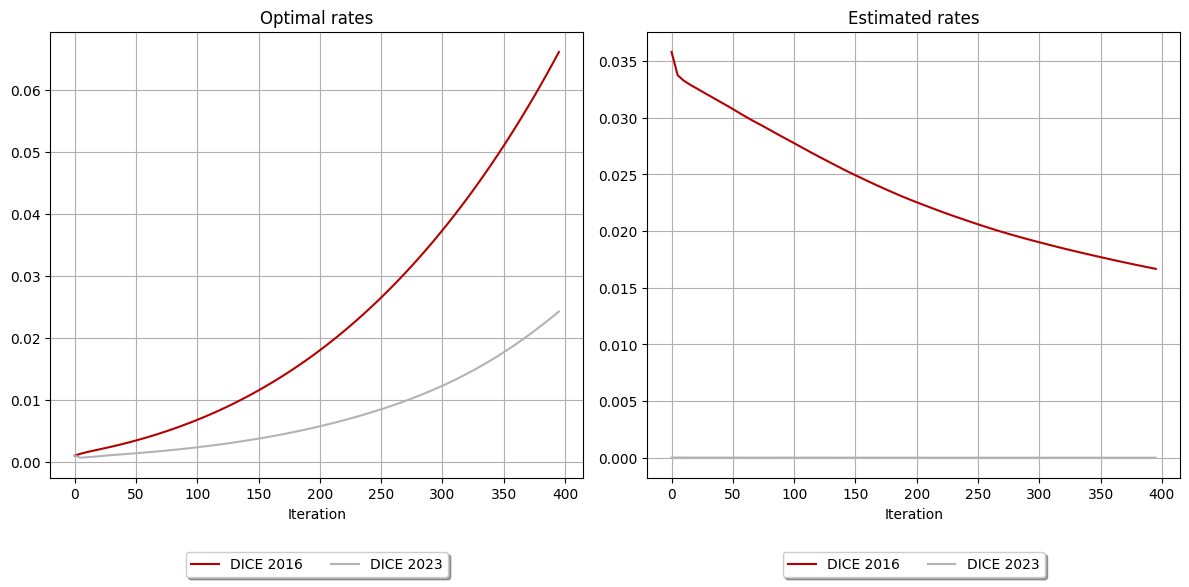

In [127]:
# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# First subplot for normal MSE values
ax1.plot(year_labels[:lm], optimal_abatement_rate_2016[:lm], label='DICE 2016', color=color_red)
ax1.plot(year_labels[:lm], optimal_abatement_rate_2023[:lm], label='DICE 2023', color=color_gray)
ax1.set_title('Optimal rates')
ax1.set_xlabel('Iteration')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
ax1.grid(True)

# Second subplot for log10 of MSE values
ax2.plot(year_labels[:lm], abatement_rate_2016[:lm], label='DICE 2016', color=color_red)
ax2.plot(year_labels[:lm], abatement_rate_2023[:lm], label='DICE 2023', color=color_gray)
ax2.set_title('Estimated rates')
ax2.set_xlabel('Iteration')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Optimal Consumption Rate

The optimal consumption rate is $x_t^* = 1-\beta\kappa$ and should be constant across all states.

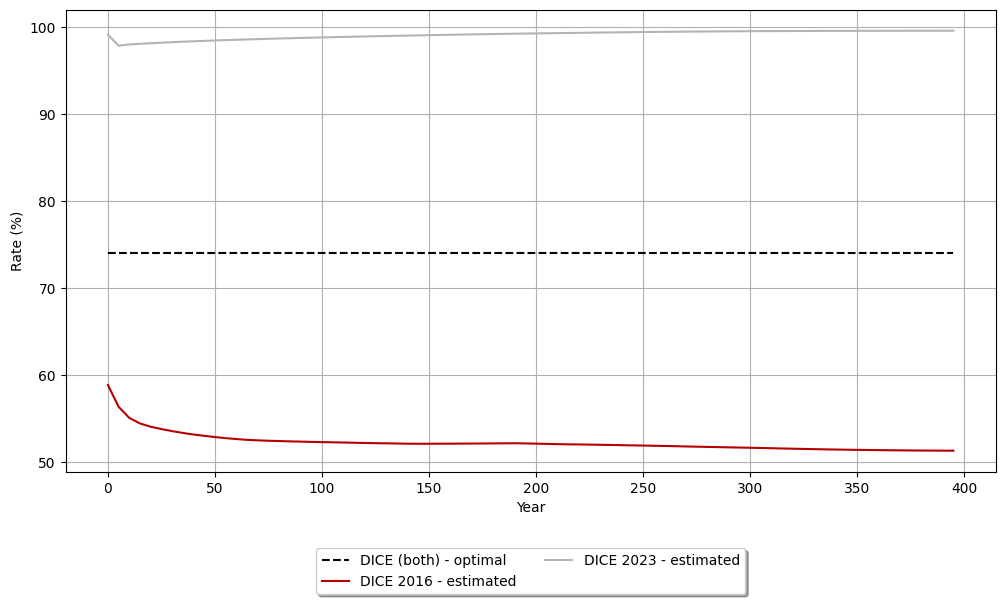

In [112]:
optimal_consumption_rate_2016 = (1-env2016.equations_of_motion.beta*env2016.equations_of_motion.kappa).numpy()
optimal_consumption_rate_2023 = (1-env2023.equations_of_motion.beta*env2023.equations_of_motion.kappa).numpy()
if not np.allclose(optimal_consumption_rate_2023 ,optimal_consumption_rate_2016):
    raise ValueError(f"Optimal consumption rates differ: {optimal_consumption_rate_2016, optimal_consumption_rate_2023}")

consumption_rate_2016 = df2016["x_t"][:num_time_steps] * 100
consumption_rate_2023 = df2023["x_t"][:num_time_steps] * 100

# Create an array filled with the constant value
lm = num_time_steps
constant_values = np.full(lm, optimal_consumption_rate_2016) * 100

plt.figure(figsize=(12, 6))
plt.plot(year_labels[:lm], constant_values[:lm], label='DICE (both) - optimal', color = color_black, linestyle='--')
plt.plot(year_labels[:lm], consumption_rate_2016[:lm], label='DICE 2016 - estimated', color = color_red)
plt.plot(year_labels[:lm], consumption_rate_2023[:lm], label='DICE 2023 - estimated', color = color_gray)
#plt.title('Optimal Consumption Rate')
plt.xlabel('Year')
plt.ylabel('Rate (%)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
plt.grid(True)
plt.show()

# Other Checks

## Exogenous Variables

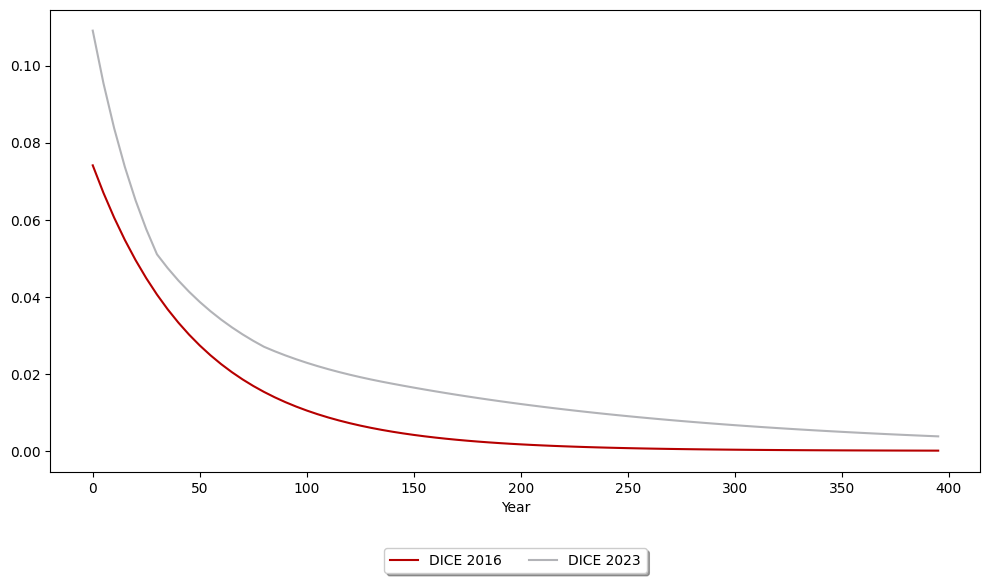

In [113]:
abatementcosts2016 = env2016.equations_of_motion.theta_1.numpy()[:num_time_steps]
abatementcosts2023 = env2023.equations_of_motion.theta_1.numpy()[:num_time_steps]

plt.figure(figsize=(12, 6))
plt.plot(year_labels, abatementcosts2016, label='DICE 2016', color = color_red)
plt.plot(year_labels, abatementcosts2023, label='DICE 2023', color = color_gray)
plt.xlabel('Year')
plt.ylabel('')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
plt.grid(False)
plt.show()

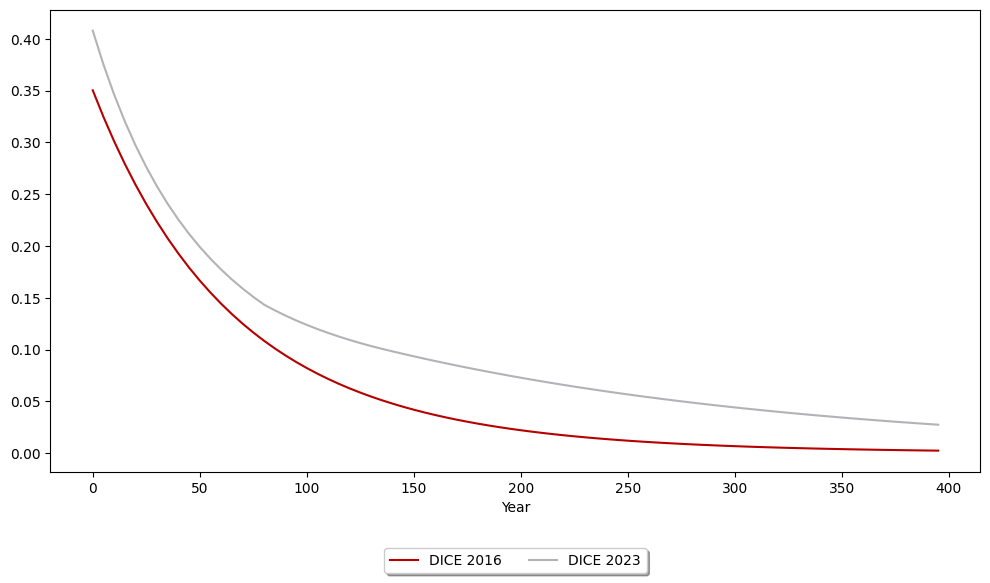

In [114]:
carbon_intensity2016 = env2016.equations_of_motion.sigma.numpy()[:num_time_steps]
carbon_intensity2023 = env2023.equations_of_motion.sigma.numpy()[:num_time_steps]

plt.figure(figsize=(12, 6))
plt.plot(year_labels, carbon_intensity2016, label='DICE 2016', color = color_red)
plt.plot(year_labels, carbon_intensity2023, label='DICE 2023', color = color_gray)
plt.xlabel('Year')
plt.ylabel('')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
plt.grid(False)
plt.show()

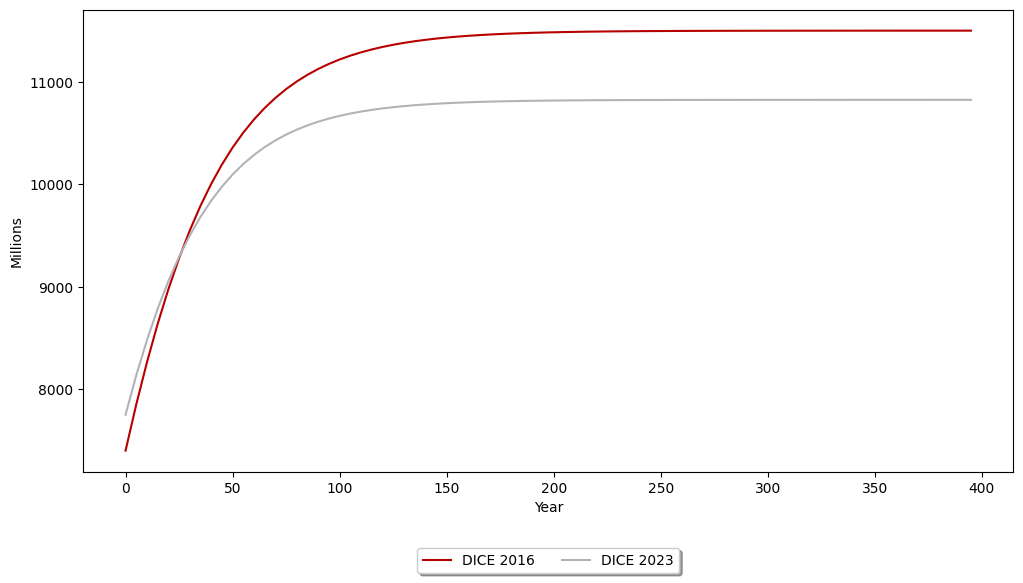

In [115]:
labor2016 = env2016.equations_of_motion.N_t.numpy()[:num_time_steps]
labor2023 = env2023.equations_of_motion.N_t.numpy()[:num_time_steps]

plt.figure(figsize=(12, 6))
plt.plot(year_labels, labor2016, label='DICE 2016', color = color_red)
plt.plot(year_labels, labor2023, label='DICE 2023', color = color_gray)
plt.xlabel('Year')
plt.ylabel('Millions')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
plt.grid(False)
plt.show()

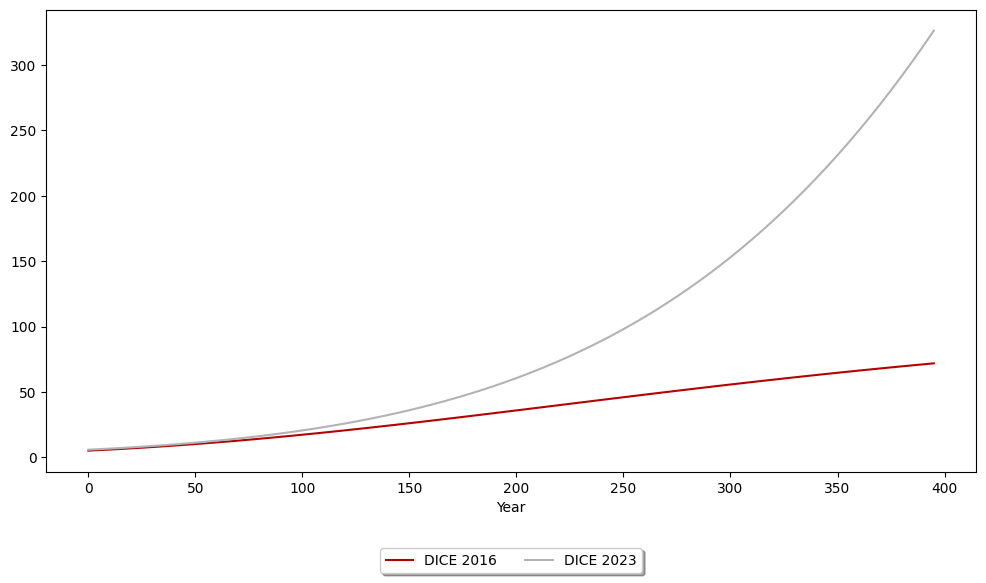

In [116]:
tfp2016 = env2016.equations_of_motion.A_t.numpy()[:num_time_steps]
tfp2023 = env2023.equations_of_motion.A_t.numpy()[:num_time_steps]

plt.figure(figsize=(12, 6))
plt.plot(year_labels, tfp2016, label='DICE 2016', color = color_red)
plt.plot(year_labels, tfp2023, label='DICE 2023', color = color_gray)
plt.xlabel('Year')
plt.ylabel('')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
plt.grid(False)
plt.show()

## Net versus Gross output

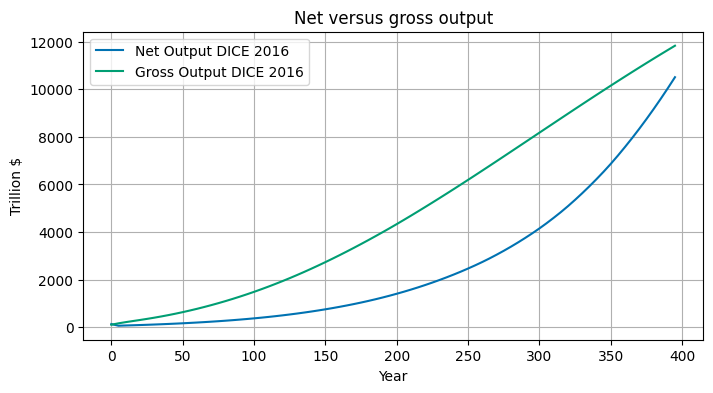

In [117]:
plt.figure(figsize=(8, 4))
plt.plot(year_labels, net_output, label='Net Output DICE 2016')
plt.plot(year_labels, gross_output2016, label='Gross Output DICE 2016')
plt.title('Net versus gross output')
plt.xlabel('Year')
plt.ylabel('Trillion $')
plt.legend()
plt.grid(True)
plt.show()

# Plotting MSE from runs

In [118]:
csv_path_r1_2016 = "mse-from-runs/2016 first 1000 epoch run, 1e-4.csv"
df_2016_errors_1 = load_csv(csv_path_r1_2016)
print(df_2016_errors_1.head())

csv_path_r1_2023 = "mse-from-runs/2023 first 1000 epoch run, 1e-4.csv"
df_2023_errors_1 = load_csv(csv_path_r1_2023)
print(df_2023_errors_1.head())


      Wall time  Step      Value
0  1.714913e+09     0  56.226734
1  1.714913e+09     1  48.272209
2  1.714913e+09     2  44.741051
3  1.714913e+09     3  43.235901
4  1.714913e+09     4  40.862221
      Wall time  Step      Value
0  1.714804e+09     0  66.400421
1  1.714804e+09     1  56.381615
2  1.714804e+09     2  51.985764
3  1.714804e+09     3  52.139790
4  1.714804e+09     4  47.363762


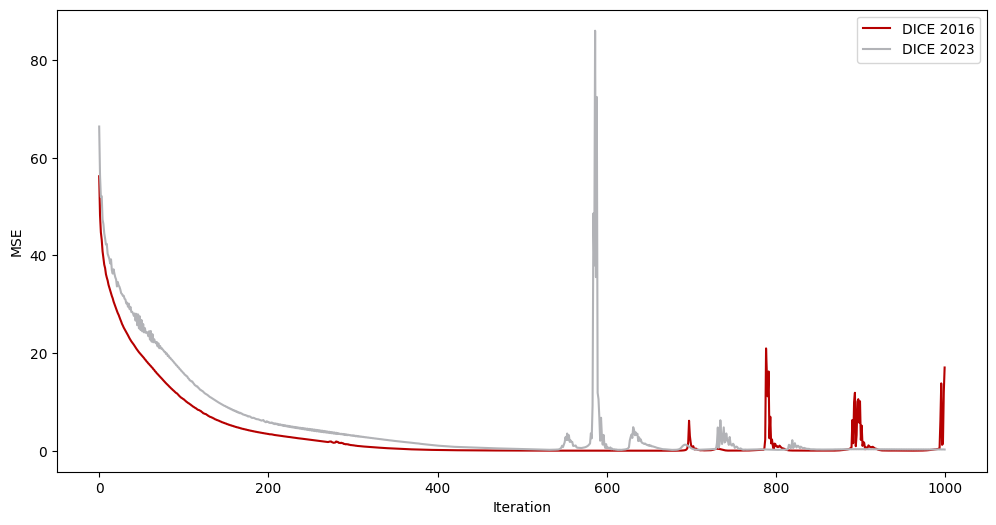

In [119]:
plt.figure(figsize=(12, 6))
plt.plot(df_2016_errors_1["Step"], df_2016_errors_1["Value"], label='DICE 2016', color=color_red)
plt.plot(df_2023_errors_1["Step"], df_2023_errors_1["Value"], label='DICE 2023', color = color_gray)
#plt.title('First run errors [64 steps, 32 batch size]')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend()
#plt.grid(True)
plt.show()

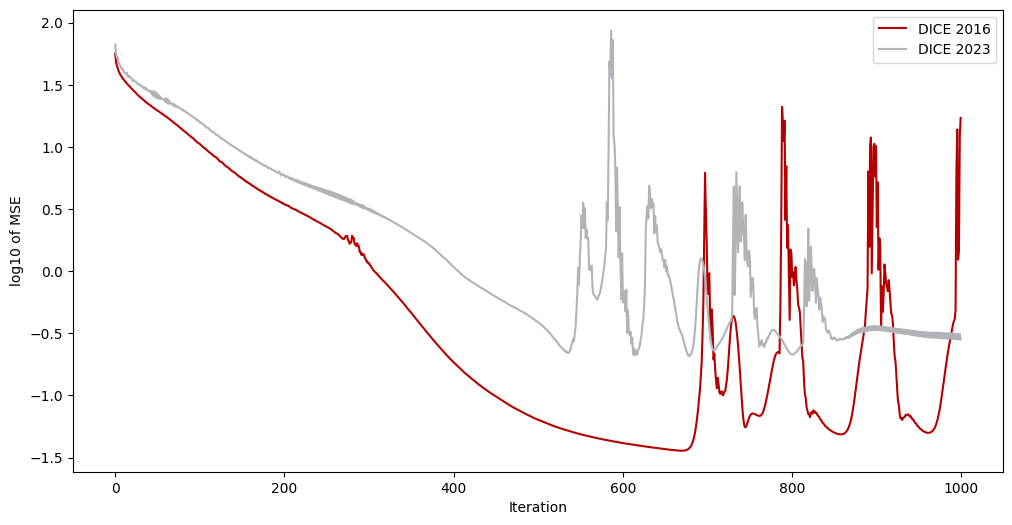

In [120]:
# Plotting with base 10 log
plt.figure(figsize=(12, 6))
plt.plot(df_2016_errors_1["Step"], np.log10(df_2016_errors_1["Value"]), label='DICE 2016', color=color_red)
plt.plot(df_2023_errors_1["Step"], np.log10(df_2023_errors_1["Value"]), label='DICE 2023', color=color_gray)
#plt.title('First run errors [64 steps, 32 batch size]')
plt.xlabel('Iteration')
plt.ylabel('log10 of MSE')
plt.legend()
#plt.grid(True)
plt.show()

In [121]:
csv_path_r2_2016 = "mse-from-runs/2016 second 2000 epoch run, 1e-4.csv"
df_2016_errors_2 = load_csv(csv_path_r2_2016)
df_2016_errors_2

csv_path_r2_2023 = "mse-from-runs/2023 second 2000 epoch run, 1e-4.csv"
df_2023_errors_2 = load_csv(csv_path_r2_2023)
df_2023_errors_2

,Wall time,Step,Value
0,1.714811e+09,5,6893.489258
1,1.714811e+09,6,20577.222656
2,1.714811e+09,10,6173.789062
3,1.714811e+09,11,490.419067
4,1.714811e+09,13,4108.667969
...,...,...,...
995,1.714831e+09,1982,9.660375
996,1.714831e+09,1983,9.528367
997,1.714831e+09,1995,8.074130
998,1.714831e+09,1997,7.853552


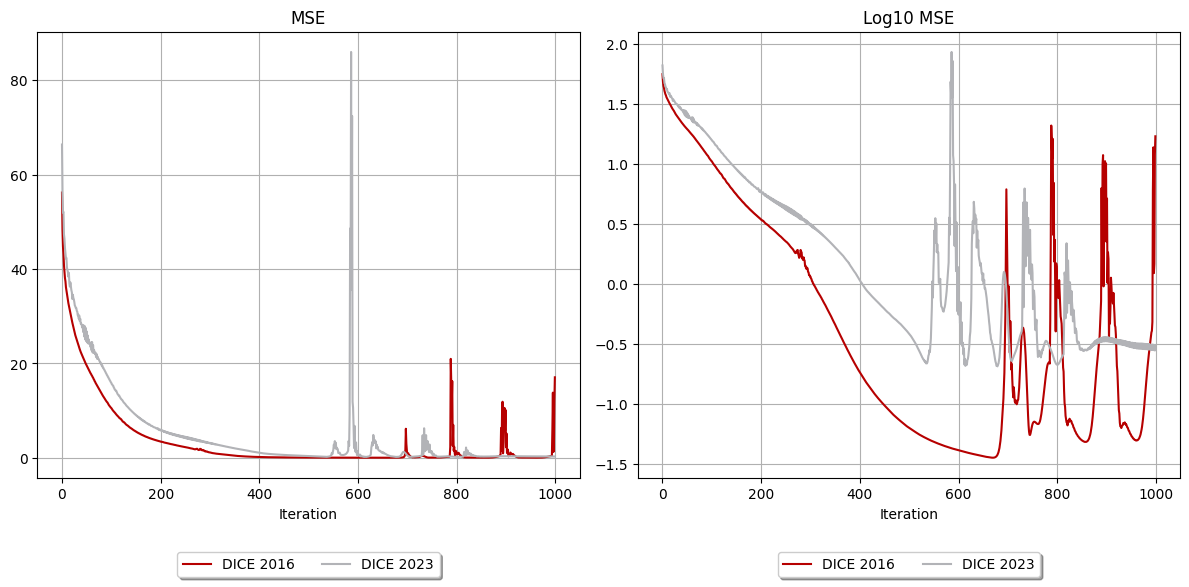

In [122]:

# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# First subplot for normal MSE values
ax1.plot(df_2016_errors_1["Step"], df_2016_errors_1["Value"], label='DICE 2016', color=color_red)
ax1.plot(df_2023_errors_1["Step"], df_2023_errors_1["Value"], label='DICE 2023', color=color_gray)
ax1.set_title('MSE')
ax1.set_xlabel('Iteration')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
ax1.grid(True)

# Second subplot for log10 of MSE values
ax2.plot(df_2016_errors_1["Step"], np.log10(df_2016_errors_1["Value"]), label='DICE 2016', color=color_red)
ax2.plot(df_2023_errors_1["Step"], np.log10(df_2023_errors_1["Value"]), label='DICE 2023', color=color_gray)
ax2.set_title('Log10 MSE')
ax2.set_xlabel('Iteration')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

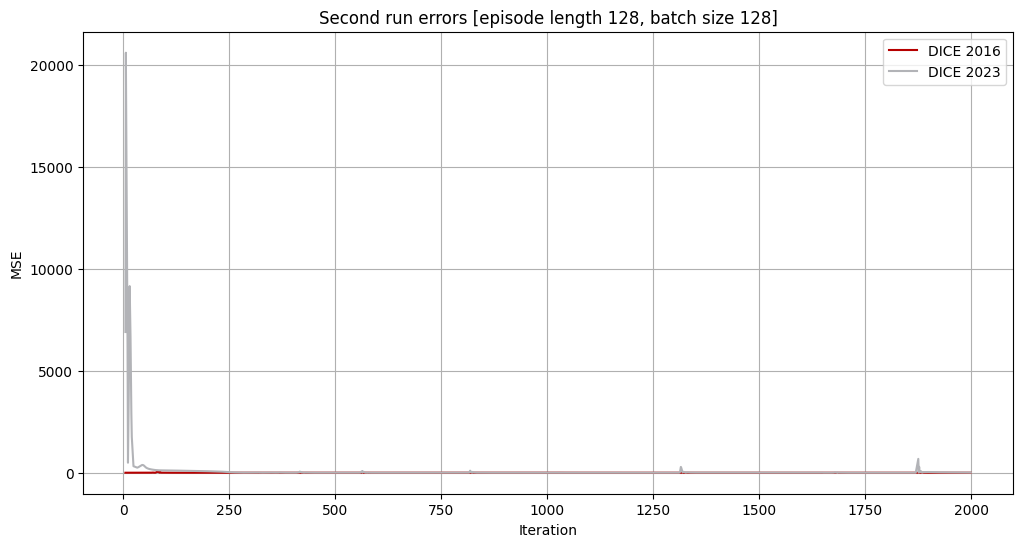

In [123]:
plt.figure(figsize=(12, 6))
plt.plot(df_2016_errors_2["Step"], df_2016_errors_2["Value"], label='DICE 2016', color=color_red)
plt.plot(df_2023_errors_2["Step"], df_2023_errors_2["Value"], label='DICE 2023', color=color_gray)
plt.title('Second run errors [episode length 128, batch size 128]')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

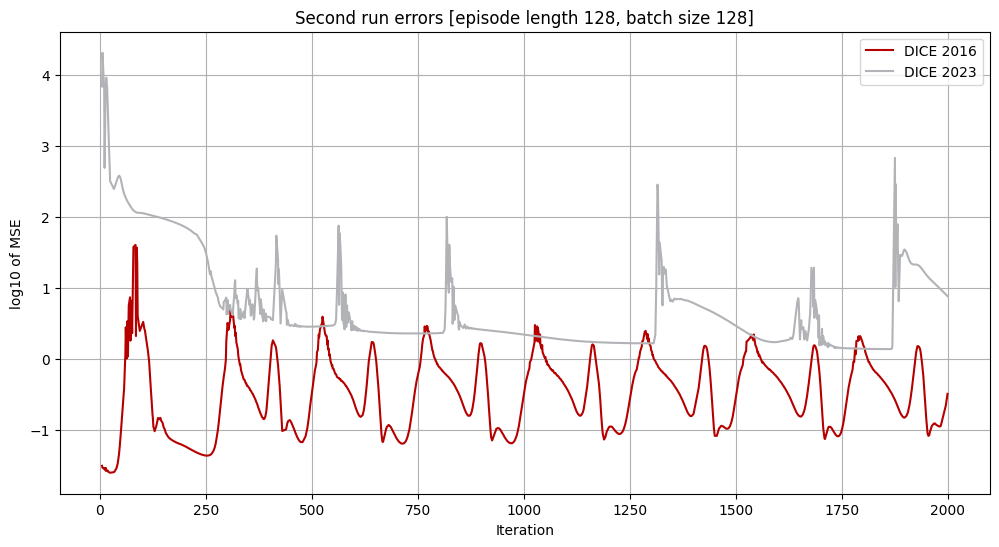

In [124]:
plt.figure(figsize=(12, 6))
plt.plot(df_2016_errors_2["Step"], np.log10(df_2016_errors_2["Value"]), label='DICE 2016', color=color_red)
plt.plot(df_2023_errors_2["Step"], np.log10(df_2023_errors_2["Value"]), label='DICE 2023', color=color_gray)
plt.title('Second run errors [episode length 128, batch size 128]')
plt.xlabel('Iteration')
plt.ylabel('log10 of MSE')
plt.legend()
plt.grid(True)
plt.show()

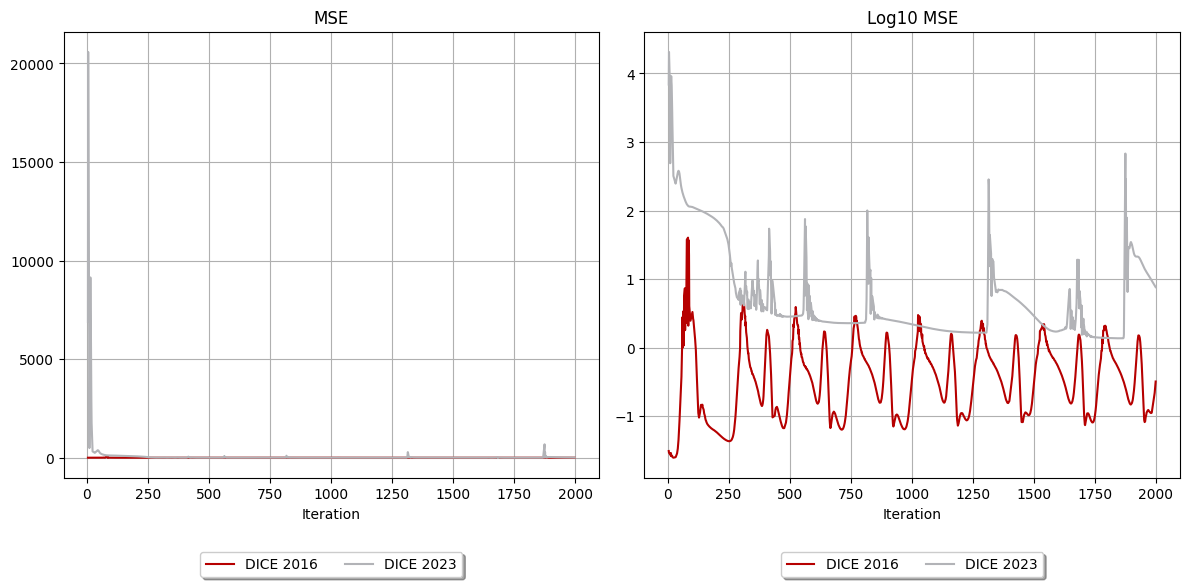

In [125]:
# Plotting second run statistics together
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# First subplot for normal MSE values
ax1.plot(df_2016_errors_2["Step"], df_2016_errors_2["Value"], label='DICE 2016', color=color_red)
ax1.plot(df_2023_errors_2["Step"], df_2023_errors_2["Value"], label='DICE 2023', color=color_gray)
ax1.set_title('MSE')
ax1.set_xlabel('Iteration')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
ax1.grid(True)

# Second subplot for log10 of MSE values
ax2.plot(df_2016_errors_2["Step"], np.log10(df_2016_errors_2["Value"]), label='DICE 2016', color=color_red)
ax2.plot(df_2023_errors_2["Step"], np.log10(df_2023_errors_2["Value"]), label='DICE 2023', color=color_gray)
ax2.set_title('Log10 MSE')
ax2.set_xlabel('Iteration')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
